In [1]:
# !pip install seaborn
# !pip install scipy
# !pip install geopandas
# !pip install imageio

import pandas as pd
import pickle
import json
import requests
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
from scipy import signal
from datetime import date,timedelta
import yaml
import os
import copy
import numpy as np
from itertools import zip_longest
import geopandas as gpd
from shapely.geometry import Polygon
import imageio

from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

cmap = plt.cm.YlOrRd.copy()
cmap.set_bad('lightgrey',1.)

/tmp/ipykernel_840214/3909578464.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# shell download and unzip
!rm -rf cb_2018_us_state_500k
!curl https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip > ./cb_2018_us_state_500k.zip
!mkdir cb_2018_us_state_500k && cd cb_2018_us_state_500k && unzip ../cb_2018_us_state_500k.zip

gdf0 = gpd.read_file('./cb_2018_us_state_500k')
territories = ['MP','VI','GU','AS','PR','DC']
gdf0 = gdf0[~gdf0.STUSPS.isin(territories)]
states = gdf0.STUSPS

state_to_abbrev_d = {"Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC", "American Samoa": "AS", "Guam": "GU", "Northern Mariana Islands": "MP", "Puerto Rico": "PR", "United States Minor Outlying Islands": "UM", "U.S. Virgin Islands": "VI"}
def state_to_abbrev(x):
    return state_to_abbrev_d[x] if x in state_to_abbrev_d else '??'

def USmap(data, scalarcmap=None):
    if scalarcmap is None:
        scalarcmap = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-2, vmax=10, clip=True))
    gdf = gdf0.merge(data.rename('data'), on='STUSPS', how='left').fillna(0.)
    gdf['value_determined_color'] = gdf['data'].apply(lambda x: mcolors.to_hex(scalarcmap.to_rgba(x)))
    # equal area projection for USA
    visframe = gdf.to_crs({'init':'epsg:2163'})

    fig, ax = plt.subplots(1, figsize=(18, 14))
    # remove the axis box around the vis
    ax.axis('off')
    for i, row in visframe.iterrows():
        if row['STUSPS'] not in ['AK','HI']:
            vf = visframe[visframe['STUSPS']==row['STUSPS']]
            c = gdf[gdf['STUSPS']==row['STUSPS']][0:1].value_determined_color.item()
            vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

    # add Alaska
    akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
    akax.axis('off')
    # polygon to clip western islands
    polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
    alaska_gdf = gdf[gdf['STUSPS']=='AK']
    alaska_gdf.clip(polygon).plot(color=gdf[gdf['STUSPS']=='AK'].value_determined_color.item(), linewidth=0.8,ax=akax, edgecolor='0.8')

    # add Hawaii
    hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
    hiax.axis('off')
    # polygon to clip western islands
    hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
    hawaii_gdf = gdf[gdf['STUSPS']=='HI']
    hawaii_gdf.clip(hipolygon).plot(color=hawaii_gdf['value_determined_color'].item(), linewidth=0.8,ax=hiax, edgecolor='0.8')

    return fig, ax

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3227k    0 3227k    0     0  4048k      0 --:--:-- --:--:-- --:--:-- 4049k
Archive:  ../cb_2018_us_state_500k.zip
  inflating: cb_2018_us_state_500k.shp.ea.iso.xml  
  inflating: cb_2018_us_state_500k.shp.iso.xml  
  inflating: cb_2018_us_state_500k.shp  
  inflating: cb_2018_us_state_500k.shx  
  inflating: cb_2018_us_state_500k.dbf  
  inflating: cb_2018_us_state_500k.prj  
 extracting: cb_2018_us_state_500k.cpg  


In [3]:
from outbreak_data.authenticate_user import set_authentication
from outbreak_data import outbreak_data
import auth_token

#### authenticate

In [4]:
from outbreak_data.authenticate_user import set_authentication
set_authentication(auth_token.get_auth_token())

#### number of sites having recorded at least one sample containing BA.2.86 or a descendant over time

In [5]:
ba286_samples = outbreak_data.get_wastewater_samples_by_lineage('BA.2.86', descendants=True, min_abundance=0.02)
ba286_samples = outbreak_data.get_wastewater_metadata(ba286_samples)

https://dev.outbreak.info/wastewater_demix/query?fetch_all=true&q=abundance:>=0.02 AND crumbs:*;BA.2.86;*
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABKwxhZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABKwxhZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1
https://dev.outbreak.info/wastewater_demix/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABKwxhZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=2


collection_date
2022-05-11    1
2022-05-12    2
2022-05-13    3
2022-05-14    5
2022-05-17    6
Name: collection_date, dtype: int64


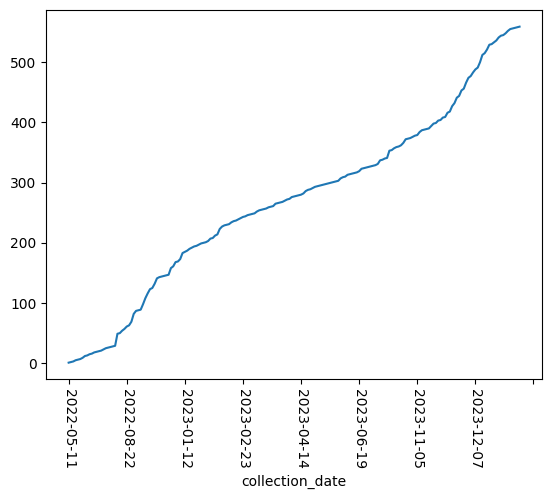

In [6]:
ba286_sites = ba286_samples.groupby('collection_site_id')['collection_date'].min()
ba286_sites = ba286_sites.groupby(ba286_sites).agg(len).sort_index().cumsum()
ba286_sites.plot(rot=-90)
print(ba286_sites.head())

#### map of date of first sample to contain BA.2.86 or a descendant

/tmp/ipykernel_840214/235573299.py:2: FutureWarning: The provided callable <built-in function min> is currently using np.minimum.reduce. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.minimum.reduce instead.
  date_third_sample = ba286_samples.groupby('STUSPS')['collection_date'].apply(min)
/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


STUSPS
??    19124.0
AK    19696.0
AL    19702.0
AR    19702.0
CA    19394.0
Name: collection_date, dtype: float64


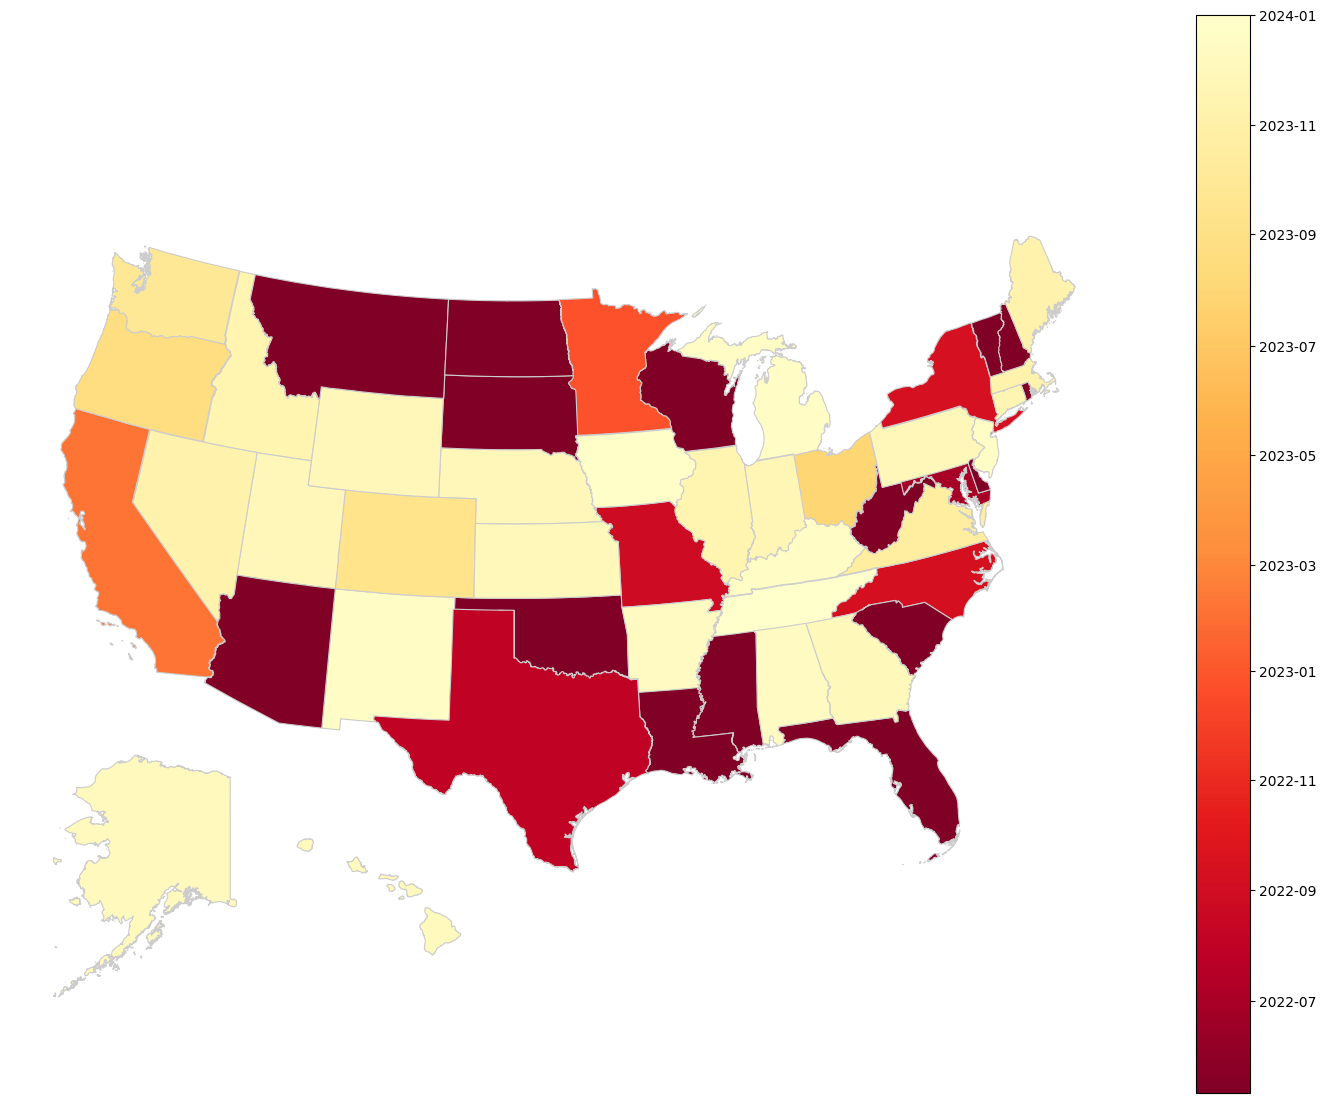

In [7]:
ba286_samples['STUSPS'] = ba286_samples['geo_loc_region'].apply(state_to_abbrev)
date_third_sample = ba286_samples.groupby('STUSPS')['collection_date'].apply(min)

date_third_sample = pd.to_datetime(date_third_sample).apply(matplotlib.dates.date2num)
datecolors = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=mcolors.Normalize(vmin=date_third_sample.min(), vmax=date_third_sample.max(), clip=True))
fig, ax = USmap(date_third_sample, datecolors)
loc = matplotlib.dates.AutoDateLocator()
fig.colorbar(datecolors, ax=ax, ticks=loc, format=matplotlib.dates.AutoDateFormatter(loc))
print(date_third_sample.head())

#### frequency of G at bp site 7842 over time in samples from one collection site

In [8]:
g7842_samples = outbreak_data.get_wastewater_samples_by_mutation(site=7842, alt_base='G', min_frequency=0.01)
g7842_samples = outbreak_data.get_wastewater_metadata(g7842_samples)

https://dev.outbreak.info/wastewater_variants/query?fetch_all=true&q=frequency:>=0.01 AND site:7842 AND alt_base:G
https://dev.outbreak.info/wastewater_variants/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABK6qRZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_variants/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABK6qRZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1


collection_date
2023-12-04    0.183354
2023-11-27    0.158220
2023-11-06    0.053362
2023-11-08    0.011680
2023-12-17    0.592946
Name: frequency, dtype: float64


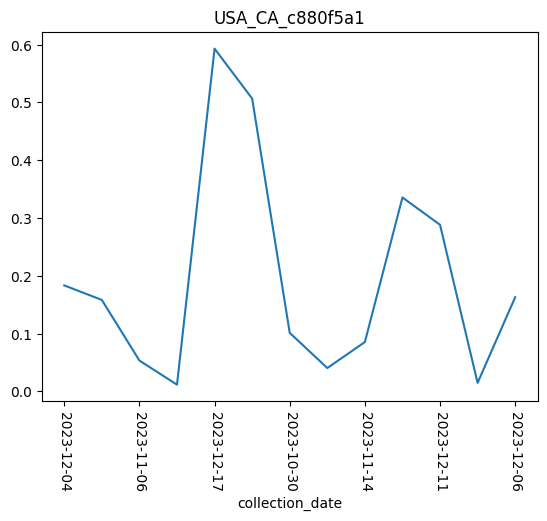

In [9]:
csite = g7842_samples['collection_site_id'][6]
freqs = g7842_samples[g7842_samples['collection_site_id'] == csite].set_index('collection_date')['frequency']
freqs.plot(rot=-90)
plt.title(csite)
print(freqs.head())

#### weighted average frequency of G at bp site 7842 over time across US samples

In [10]:
startdate, enddate = "2023-09-01", "2023-12-31"
usa_samples = outbreak_data.get_wastewater_samples(country='USA', date_range=[startdate, enddate])
print(usa_samples.head())

https://dev.outbreak.info/wastewater_metadata/query?fetch_all=true&q=geo_loc_country:USA AND collection_date:[2023-09-01 TO 2023-12-31] AND demix_success:true
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABK-8hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=0
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABK-8hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=1
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABK-8hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=2
https://dev.outbreak.info/wastewater_metadata/query?scroll_id=FGluY2x1ZGVfY29udGV4dF91dWlkDXF1ZXJ5QW5kRmV0Y2gBFnNKbEd4cUZSVEEtOXdfRy1JVV8tMmcAAAAAABK-8hZHV0dfbkk2elNUS2dCdTI1dzA4T3F3&fetch_all=True&page=3
https://dev.outbreak.

                                               7842G
date_bin                                            
(2023-08-31 00:00:00, 2023-09-03 00:00:00]  0.000000
(2023-09-03 00:00:00, 2023-09-06 00:00:00]  0.000418
(2023-09-06 00:00:00, 2023-09-09 00:00:00]  0.000000
(2023-09-09 00:00:00, 2023-09-12 00:00:00]  0.000037
(2023-09-12 00:00:00, 2023-09-15 00:00:00]  0.000004


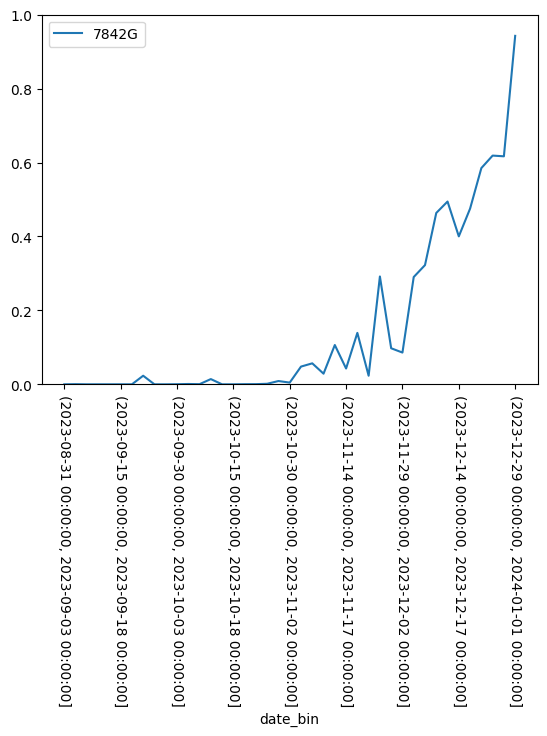

In [11]:
usa_samples_g7842 = usa_samples.copy().set_index('sra_accession')
usa_samples_g7842['frequency'] = g7842_samples.set_index('sra_accession')['frequency'].reindex(usa_samples_g7842.index).fillna(0)
usa_samples_g7842 = outbreak_data.normalize_viral_loads_by_site(usa_samples_g7842)
usa_samples_g7842['name'] = '7842G'
usa_samples_g7842 = usa_samples_g7842.rename(columns={'frequency': 'abundance'})
freqs = outbreak_data.datebin_and_agg(usa_samples_g7842, freq='3D', loaded=True, norm_abundance=False).drop(columns=['viral_load'])
freqs.plot(rot=-90)
plt.ylim(0,1)
print(freqs.head())

#### map of weighted average frequency of G at bp site 7842 in US states in sept-dec 2023

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


STUSPS  date_bin                                  
AK      (2023-09-03 00:00:00, 2023-12-29 00:00:00]    0.409156
AL      (2023-09-02 00:00:00, 2023-12-28 00:00:00]    0.258149
AR      (2023-09-01 00:00:00, 2023-12-29 00:00:00]    0.200214
CA      (2023-08-31 00:00:00, 2023-12-29 00:00:00]    0.169281
CO      (2023-08-31 00:00:00, 2023-12-16 00:00:00]    0.000000
Name: 7842G, dtype: float64


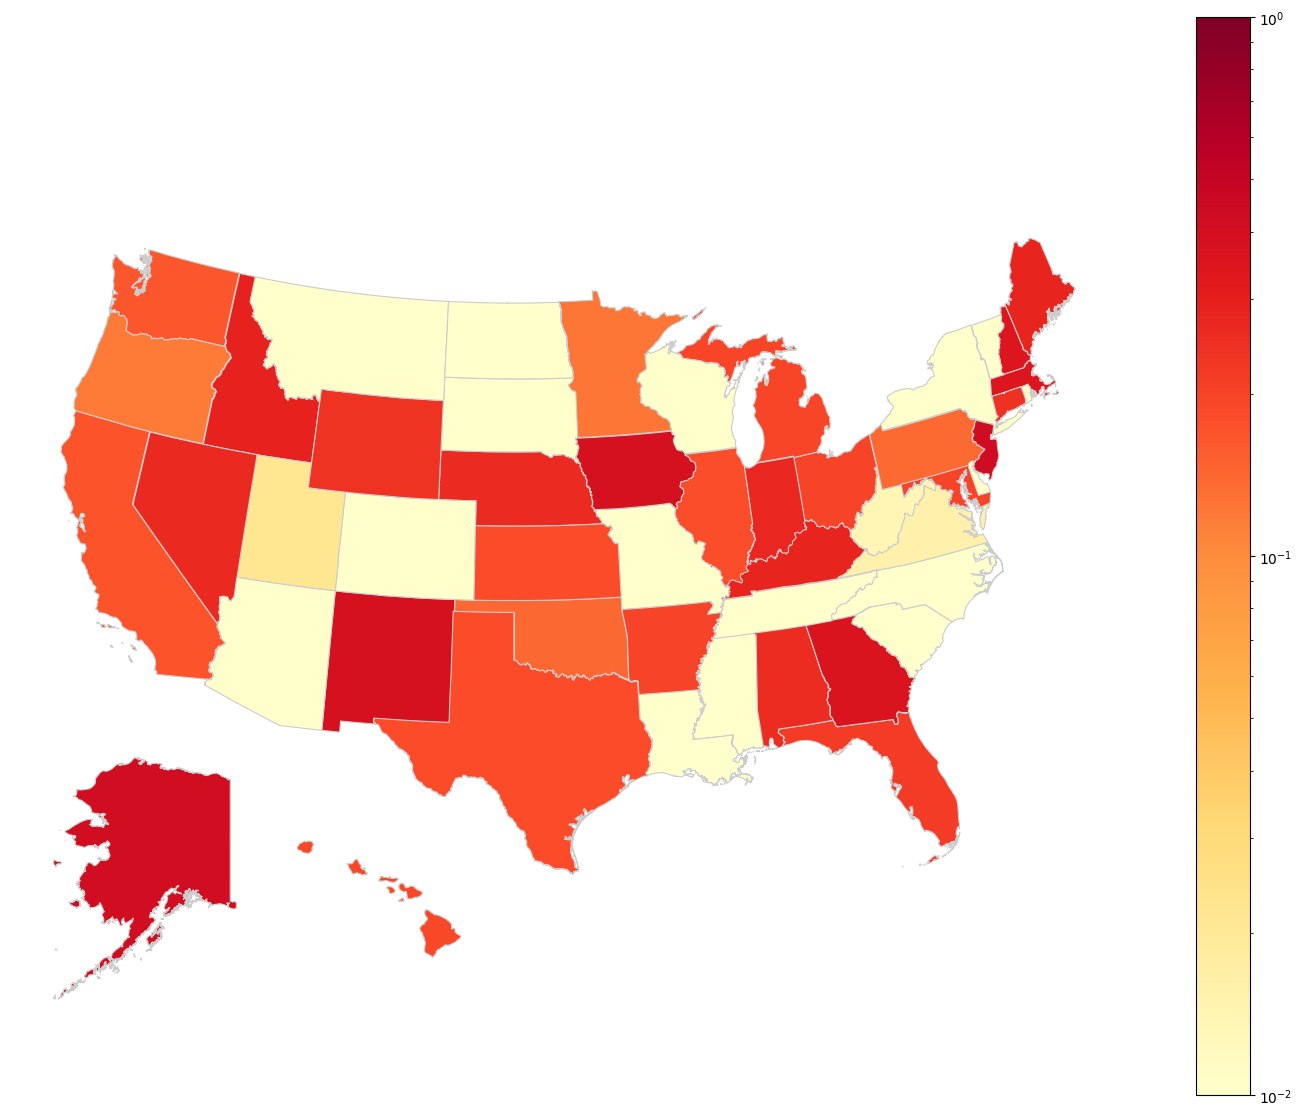

In [12]:
usa_samples_g7842['STUSPS'] = usa_samples_g7842['geo_loc_region'].apply(state_to_abbrev)
colors = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-2, vmax=1, clip=True))
freqs = usa_samples_g7842.groupby('STUSPS').apply(
        lambda x: outbreak_data.datebin_and_agg(x, freq=None, norm_abundance=False),
    include_groups=False )['7842G']
fig, ax = USmap(freqs, colors)
fig.colorbar(colors, ax=ax)
print(freqs.head())

#### animated weekly map of HV.1* abundance across US states

In [13]:
usa_samples = outbreak_data.get_wastewater_lineages(usa_samples)
print(usa_samples.head())

  collection_date collection_site_id  demix_success geo_loc_country  \
0      2023-09-03    USA_AR_7fdff14c           True             USA   
1      2023-09-03    USA_AR_7fdff14c           True             USA   
2      2023-09-03    USA_AR_7fdff14c           True             USA   
3      2023-09-03    USA_AR_7fdff14c           True             USA   
4      2023-09-03    USA_AR_7fdff14c           True             USA   

  geo_loc_region sra_accession  viral_load  ww_population        query  \
0       Arkansas   SRR26099343         NaN        93949.0  SRR26099343   
1       Arkansas   SRR26099343         NaN        93949.0  SRR26099343   
2       Arkansas   SRR26099343         NaN        93949.0  SRR26099343   
3       Arkansas   SRR26099343         NaN        93949.0  SRR26099343   
4       Arkansas   SRR26099343         NaN        93949.0  SRR26099343   

   abundance                                             crumbs     name  
0   0.031338  ;XBB;XBB.1;XBB.1.9;XBB.1.9.2;XBB.1.9.2.

In [15]:
ww_abd = outbreak_data.normalize_viral_loads_by_site(usa_samples).groupby('geo_loc_region') \
            .apply(lambda x: outbreak_data.datebin_and_agg(x.copy(), startdate=startdate, enddate=enddate, freq='7D', loaded=True))
for column in ww_abd.columns:
    if column != 'viral_load':
        ww_abd[column] = ww_abd[column].fillna(0)
print(ww_abd.iloc[:5,:5])

/tmp/ipykernel_840214/1761945666.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: outbreak_data.datebin_and_agg(x.copy(), startdate=startdate, enddate=enddate, freq='7D', loaded=True))


                                                           viral_load  \
geo_loc_region date_bin                                                 
Alabama        (2023-08-31 00:00:00, 2023-09-07 00:00:00]    0.000000   
               (2023-09-07 00:00:00, 2023-09-14 00:00:00]    0.933816   
               (2023-09-14 00:00:00, 2023-09-21 00:00:00]    1.211354   
               (2023-09-21 00:00:00, 2023-09-28 00:00:00]    0.394121   
               (2023-09-28 00:00:00, 2023-10-05 00:00:00]    0.196795   

                                                                B.1  \
geo_loc_region date_bin                                               
Alabama        (2023-08-31 00:00:00, 2023-09-07 00:00:00]  0.000000   
               (2023-09-07 00:00:00, 2023-09-14 00:00:00]  0.000743   
               (2023-09-14 00:00:00, 2023-09-21 00:00:00]  0.000000   
               (2023-09-21 00:00:00, 2023-09-28 00:00:00]  0.000000   
               (2023-09-28 00:00:00, 2023-10-05 00:00:00]  0.0

In [16]:
tree, lineage_key = outbreak_data.get_tree()

In [17]:
lin = 'HV.1'
data = ww_abd.apply(lambda x: outbreak_data.get_agg_abundance(lineage_key[lin], x), axis=1).rename('abundance').to_frame().reset_index()
print(data.head())

  geo_loc_region                                    date_bin  abundance
0        Alabama  (2023-08-31 00:00:00, 2023-09-07 00:00:00]   0.000000
1        Alabama  (2023-09-07 00:00:00, 2023-09-14 00:00:00]   0.000000
2        Alabama  (2023-09-14 00:00:00, 2023-09-21 00:00:00]   0.000181
3        Alabama  (2023-09-21 00:00:00, 2023-09-28 00:00:00]   0.000000
4        Alabama  (2023-09-28 00:00:00, 2023-10-05 00:00:00]   0.000000


/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


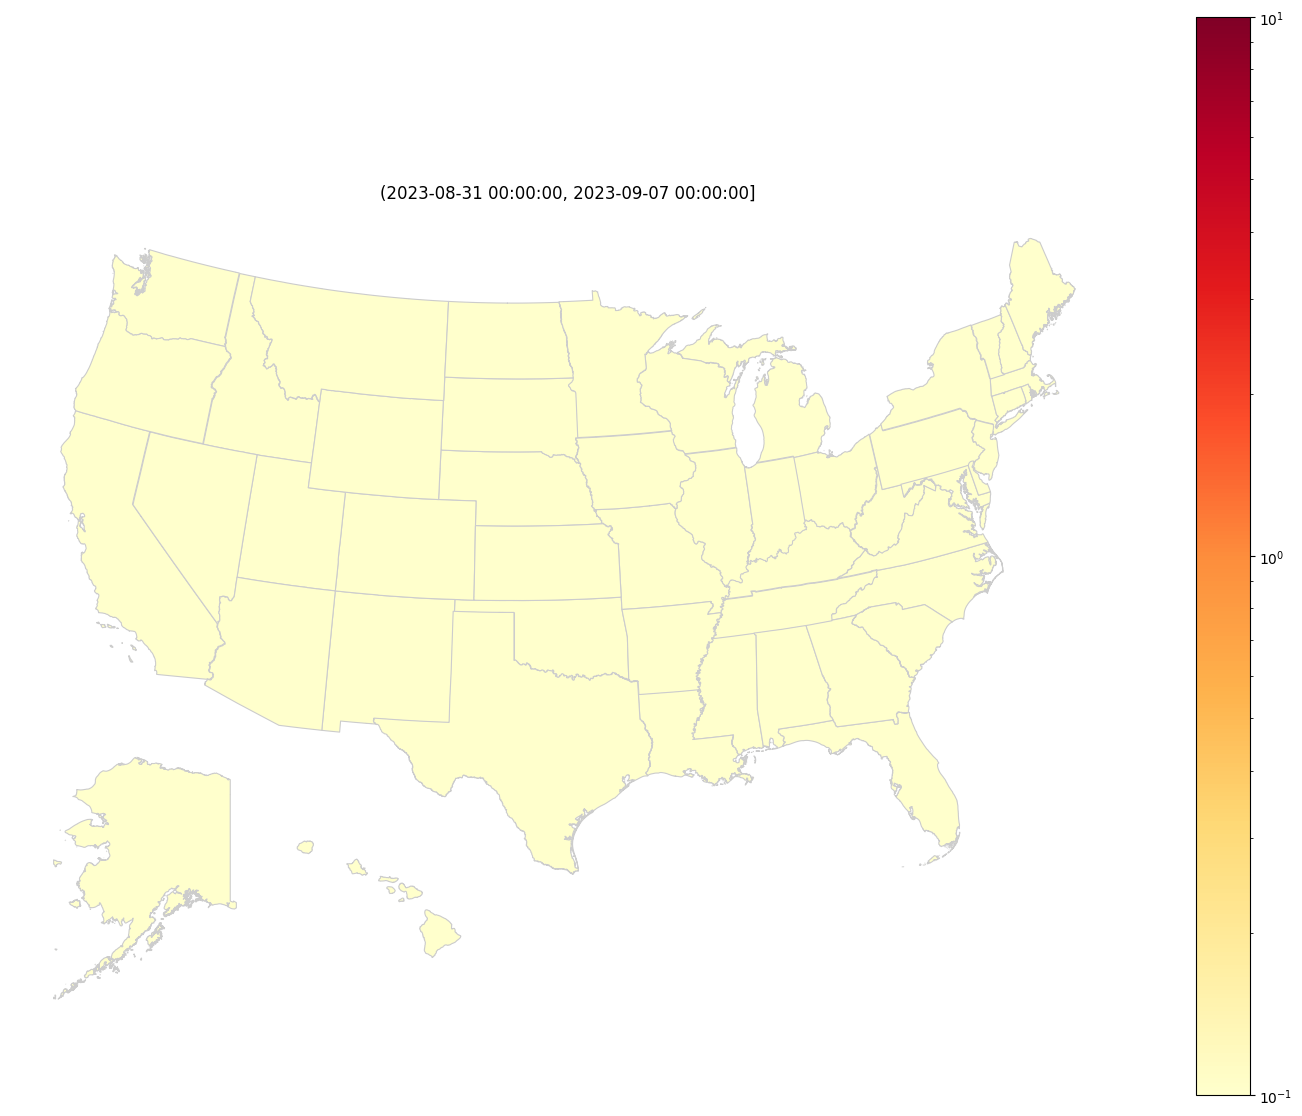

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


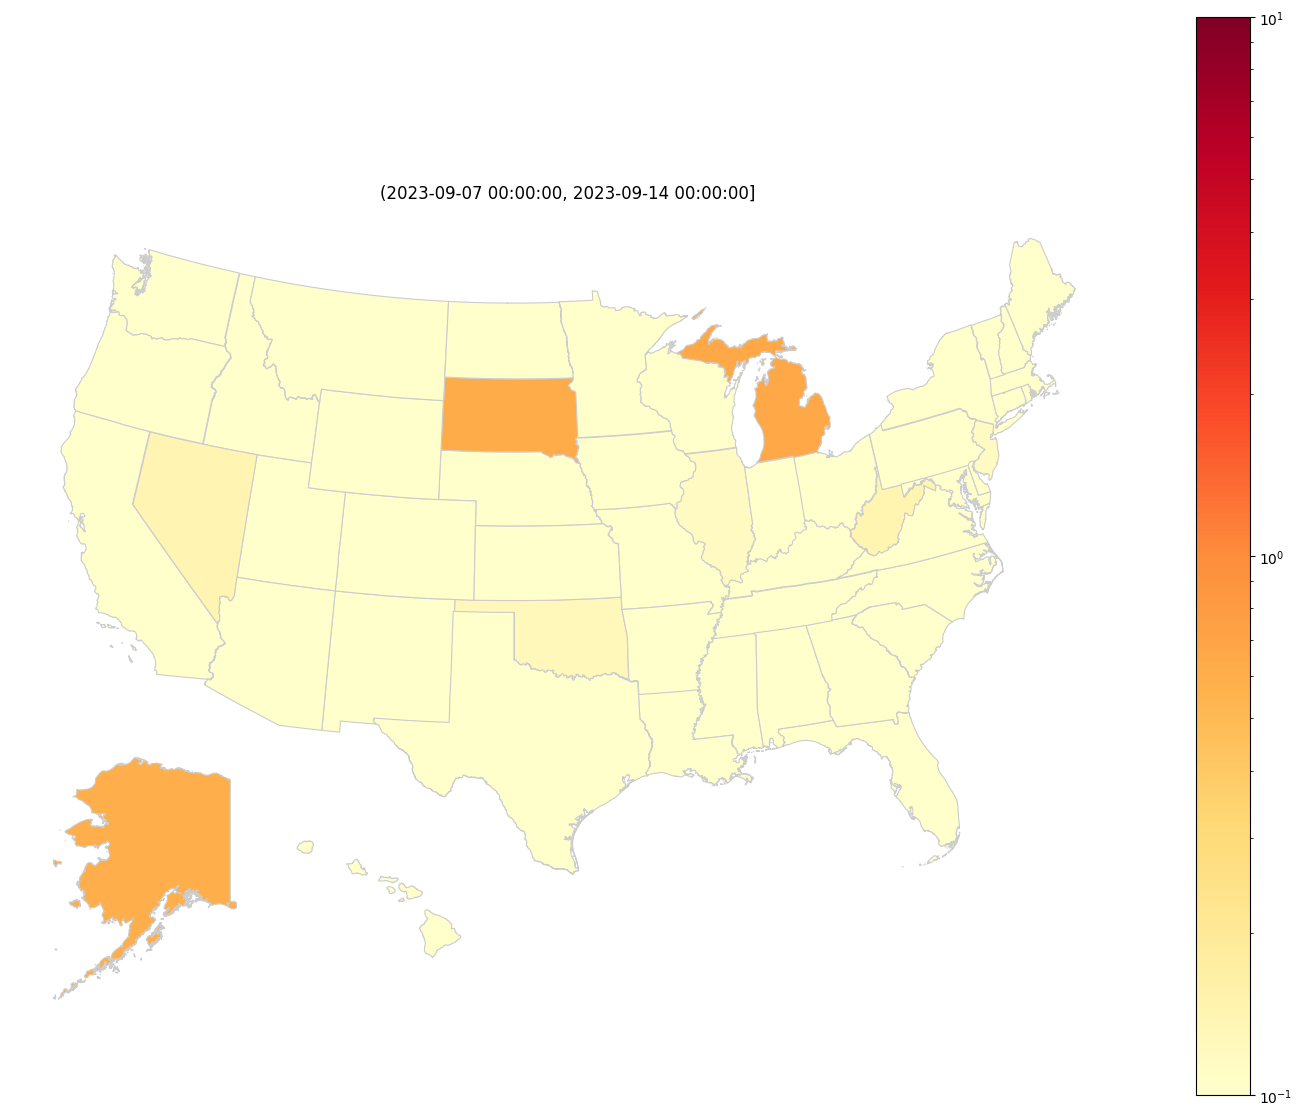

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


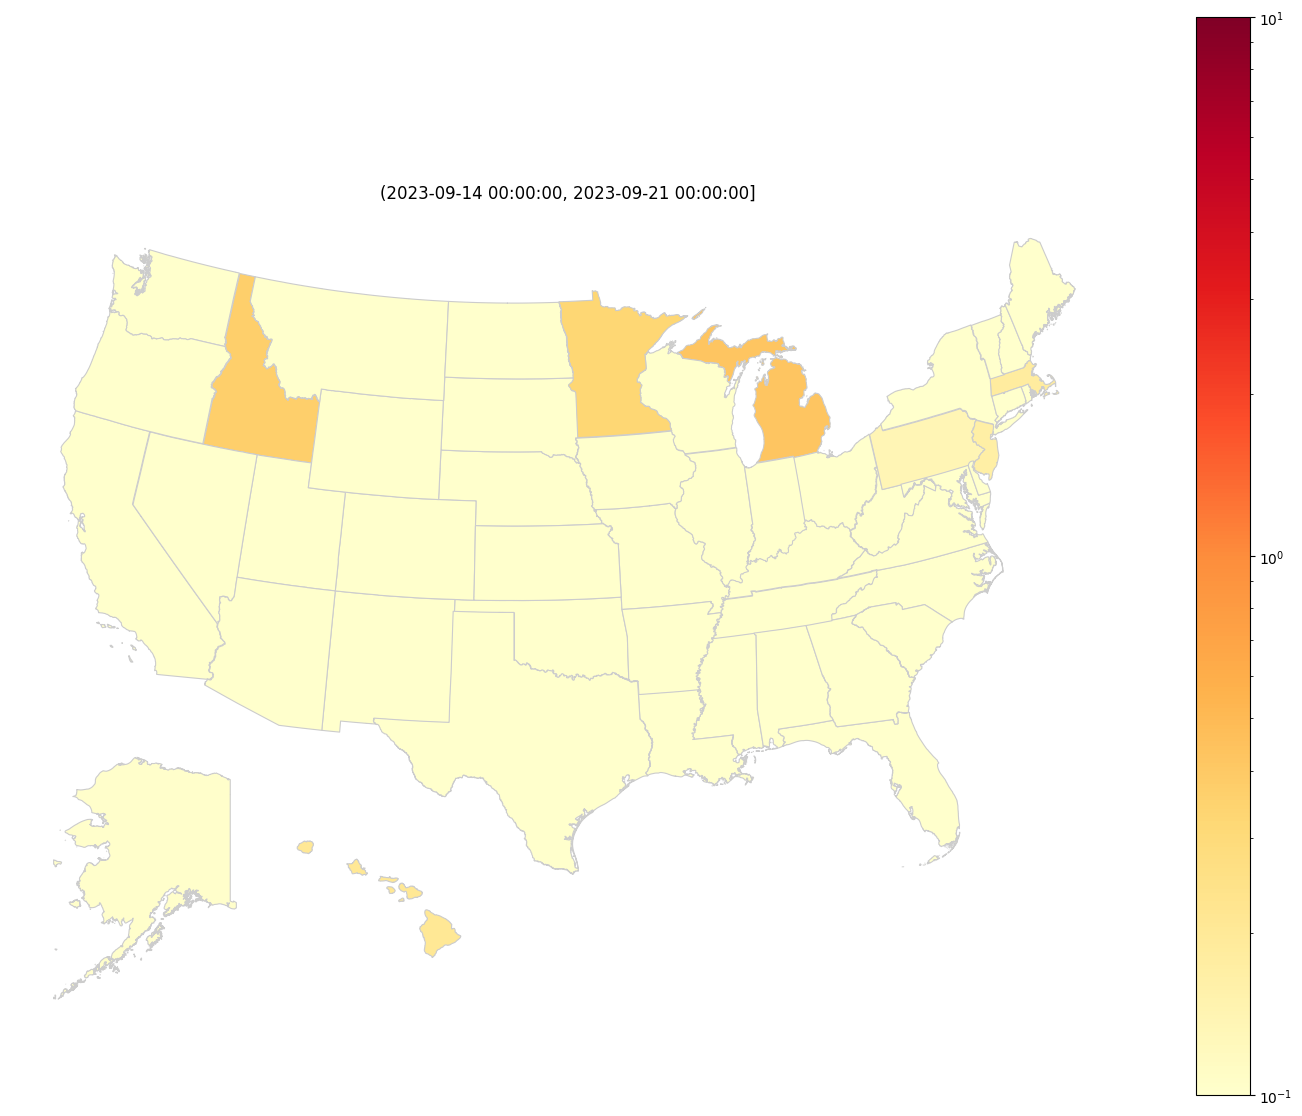

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


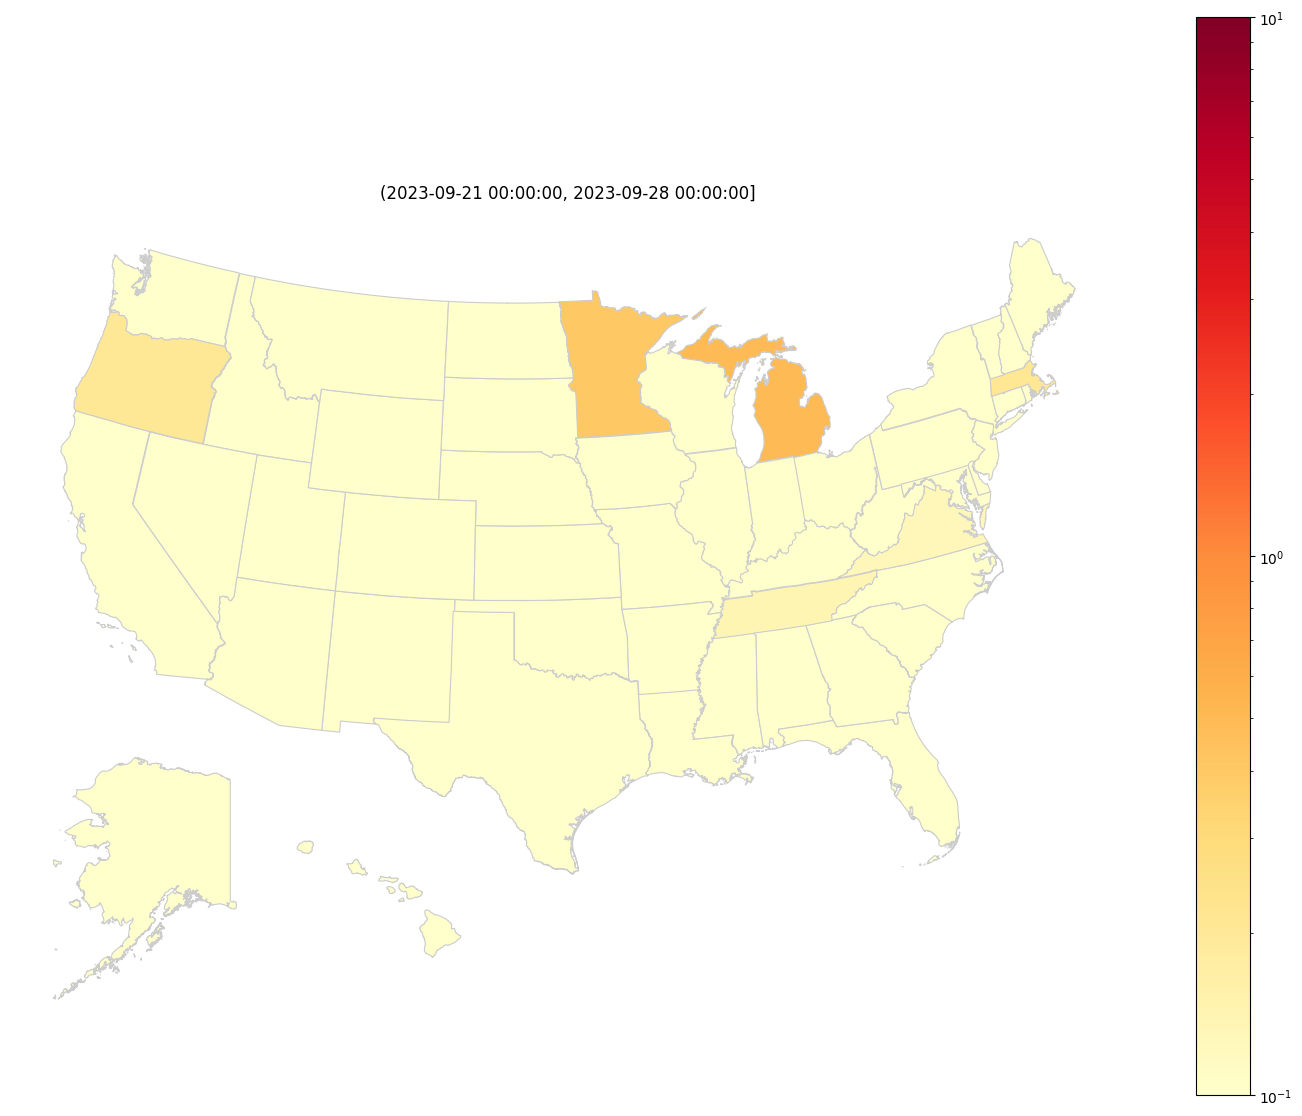

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


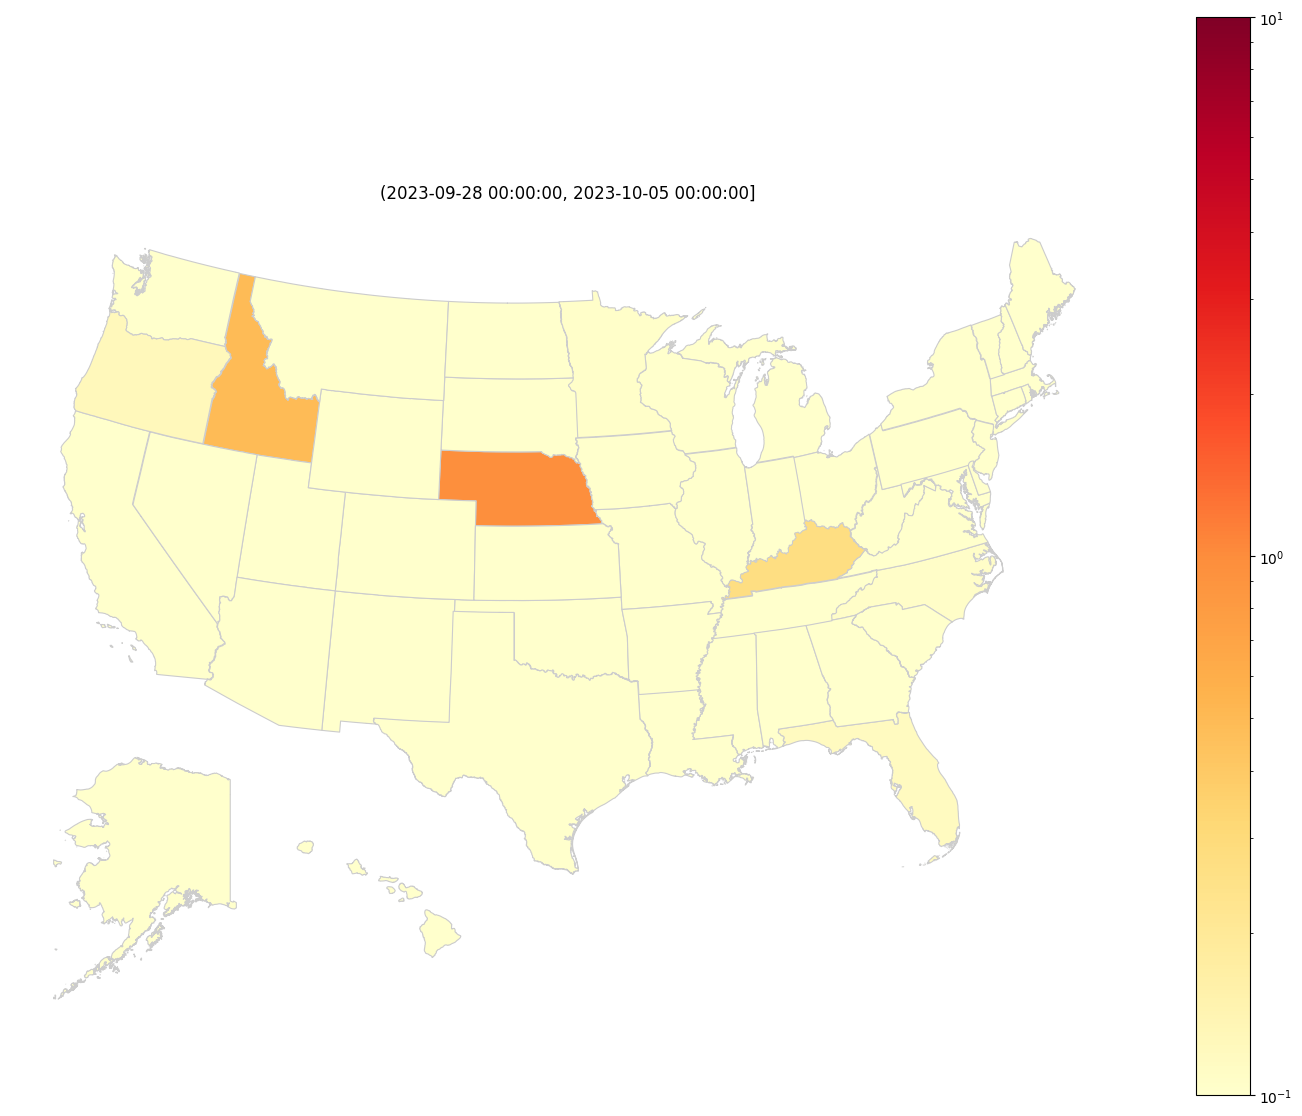

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


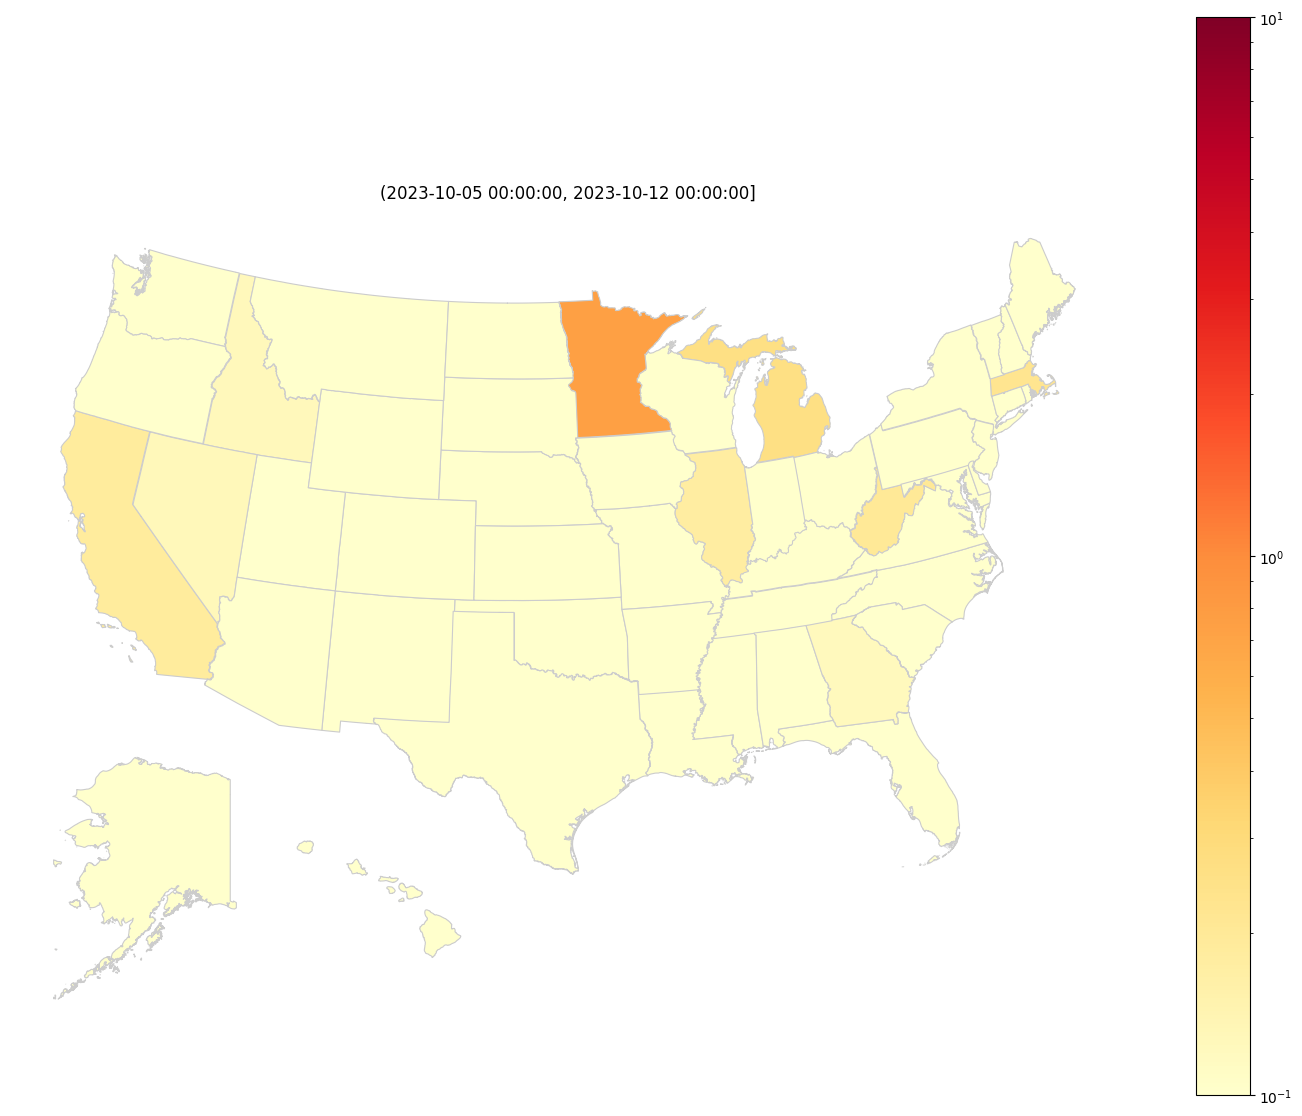

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


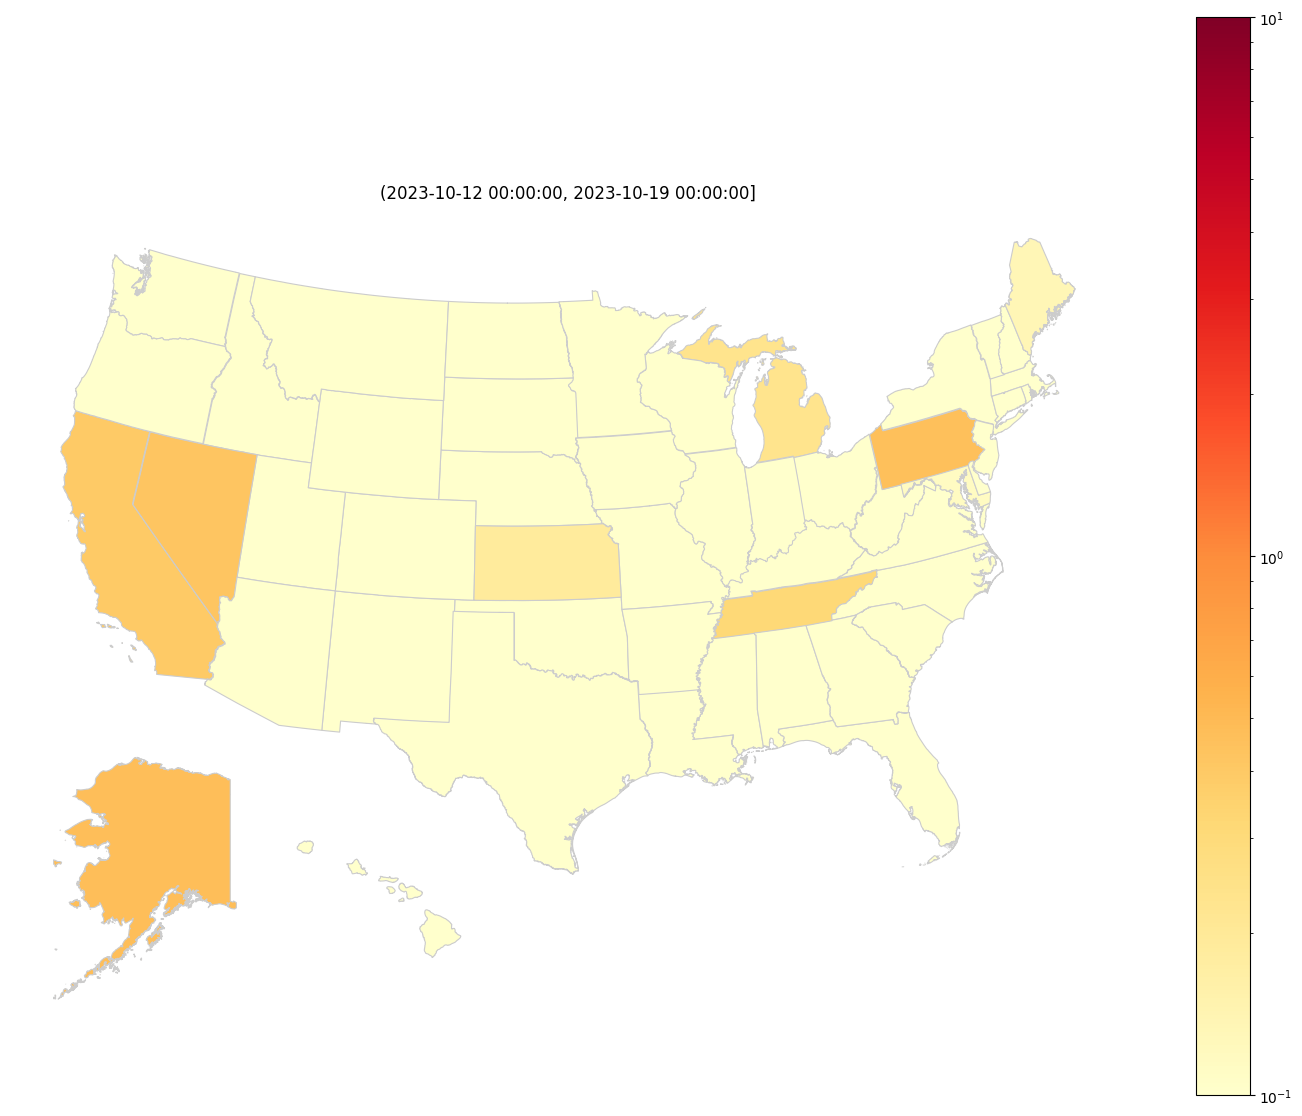

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


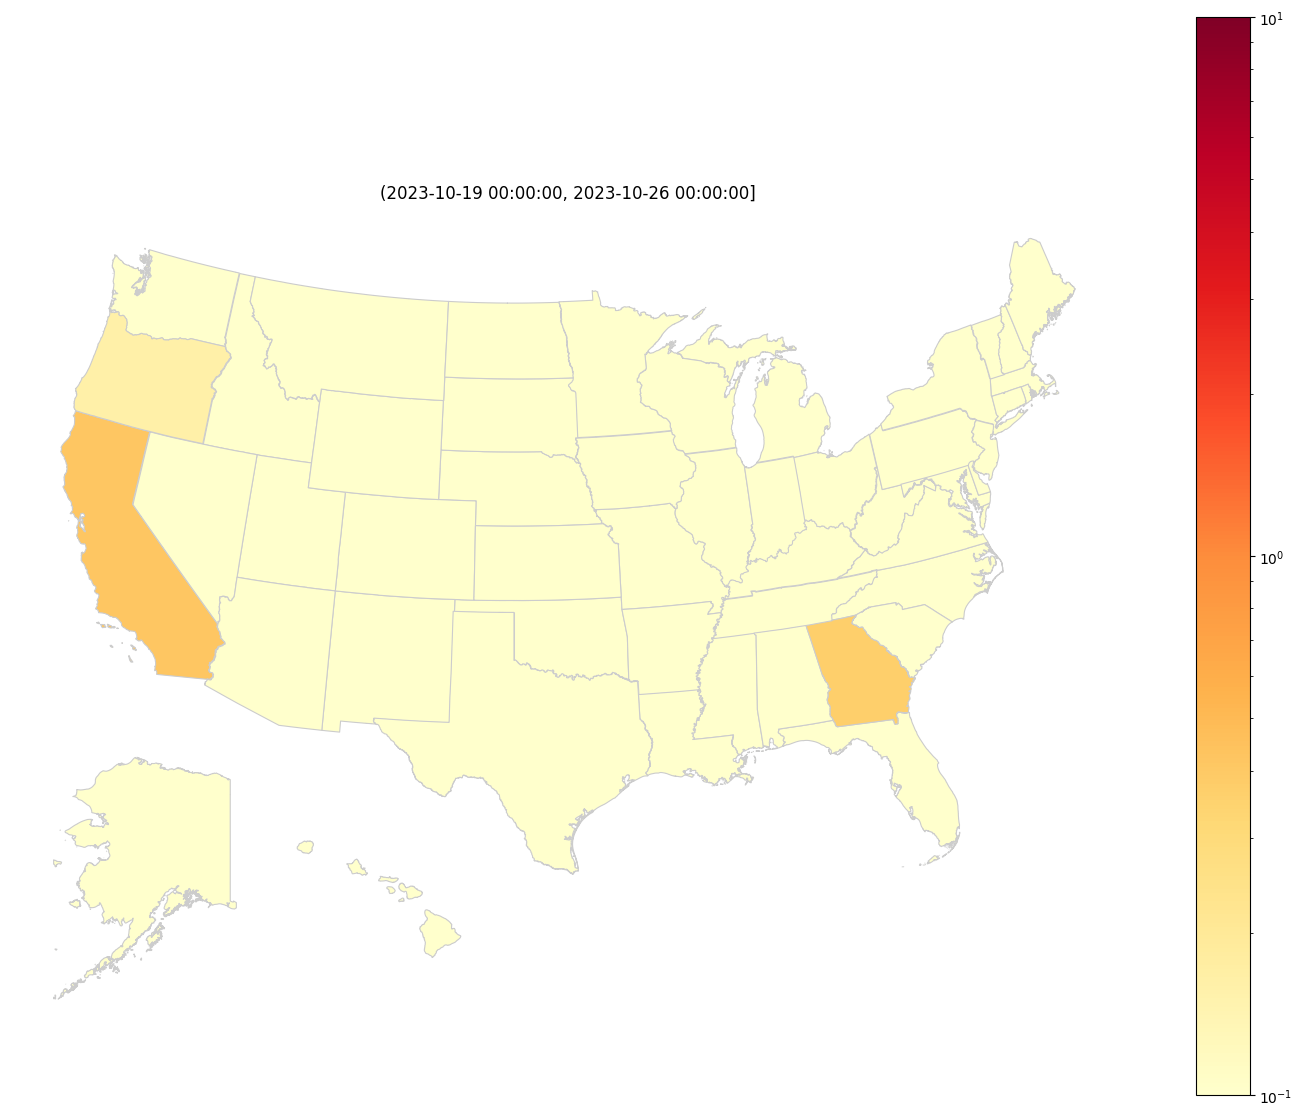

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


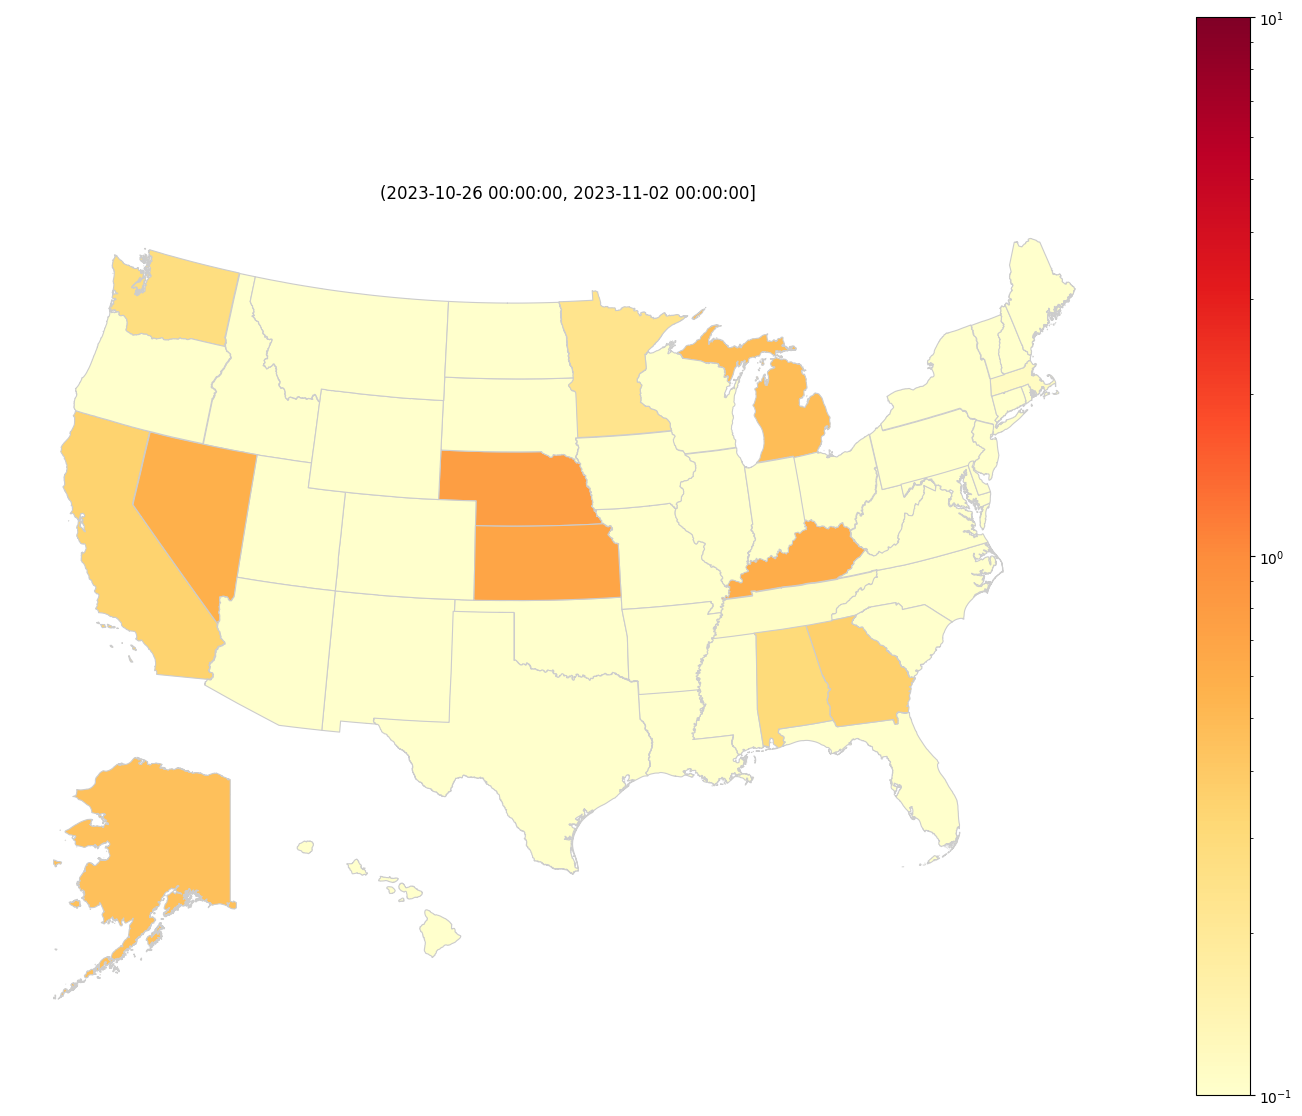

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


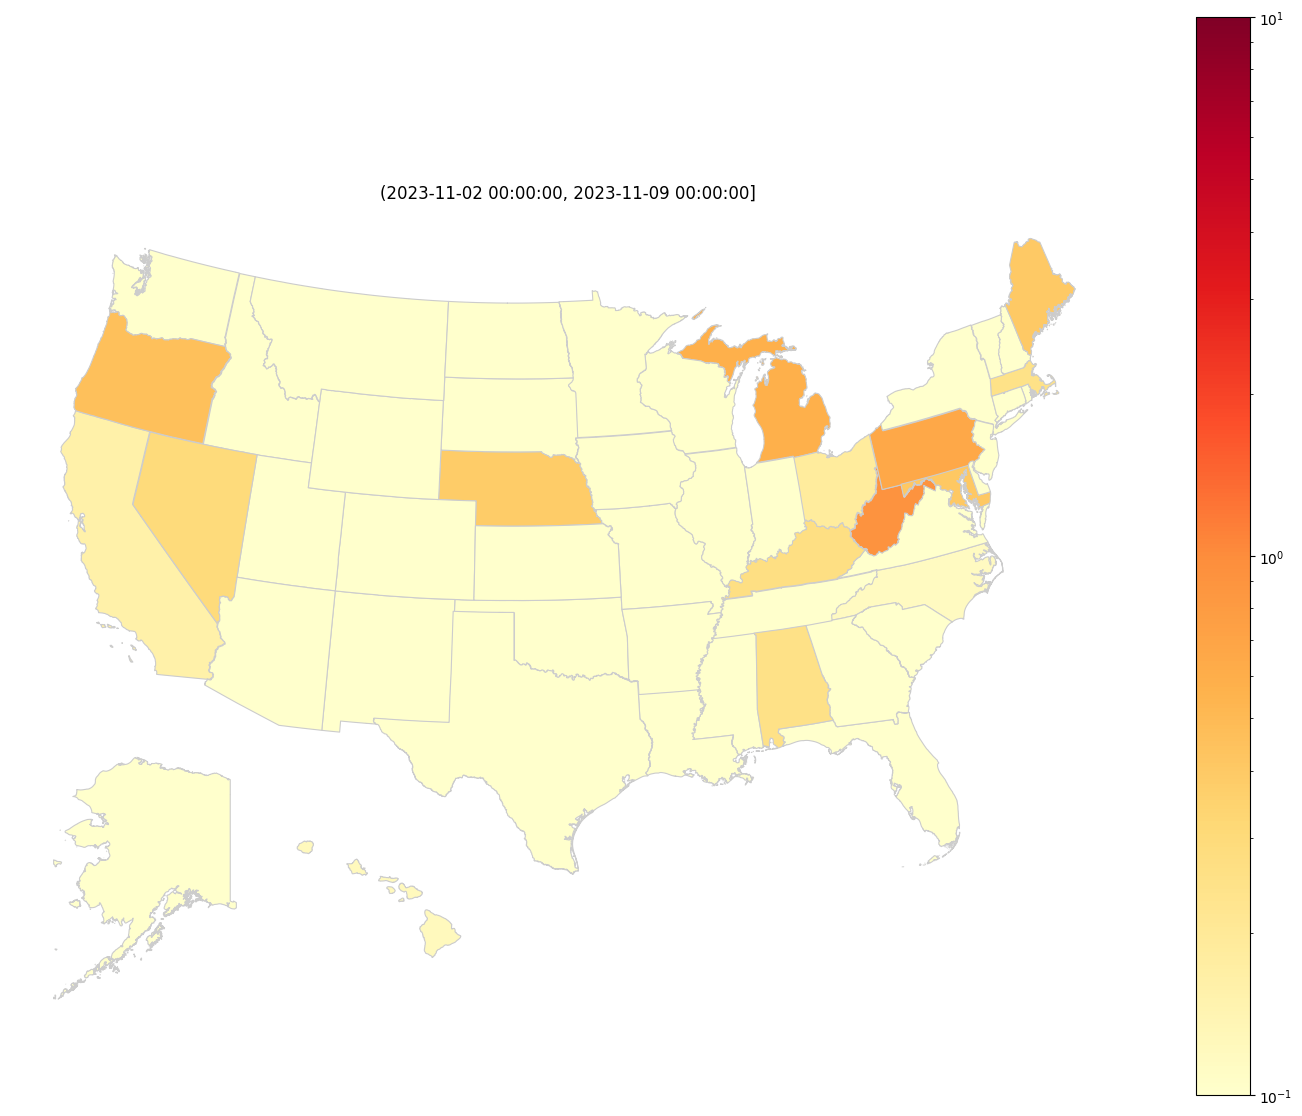

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


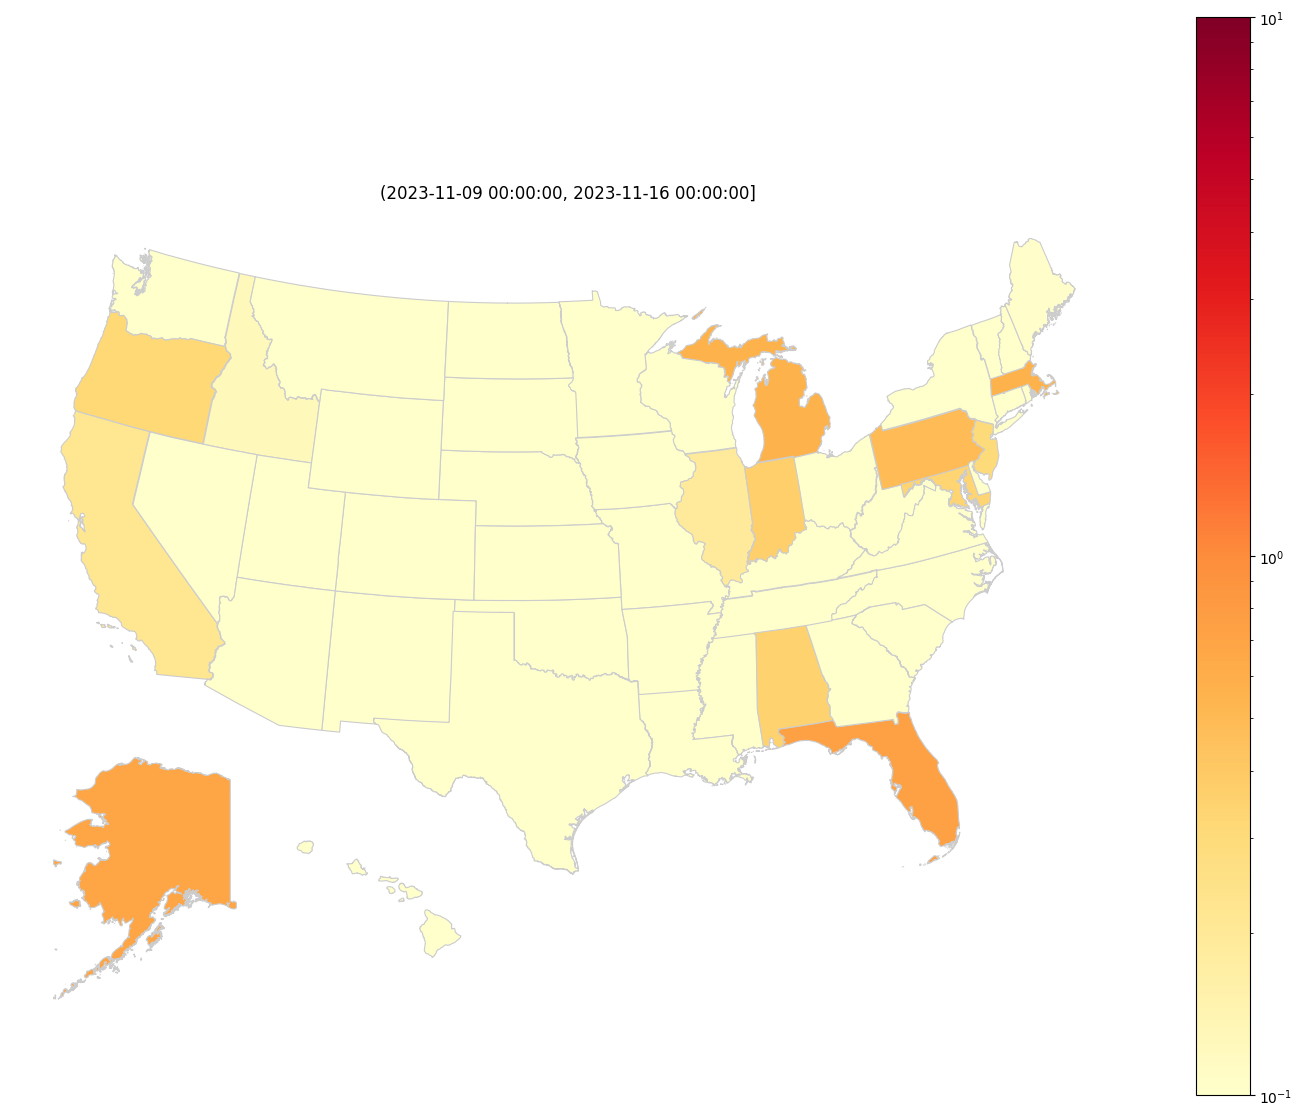

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


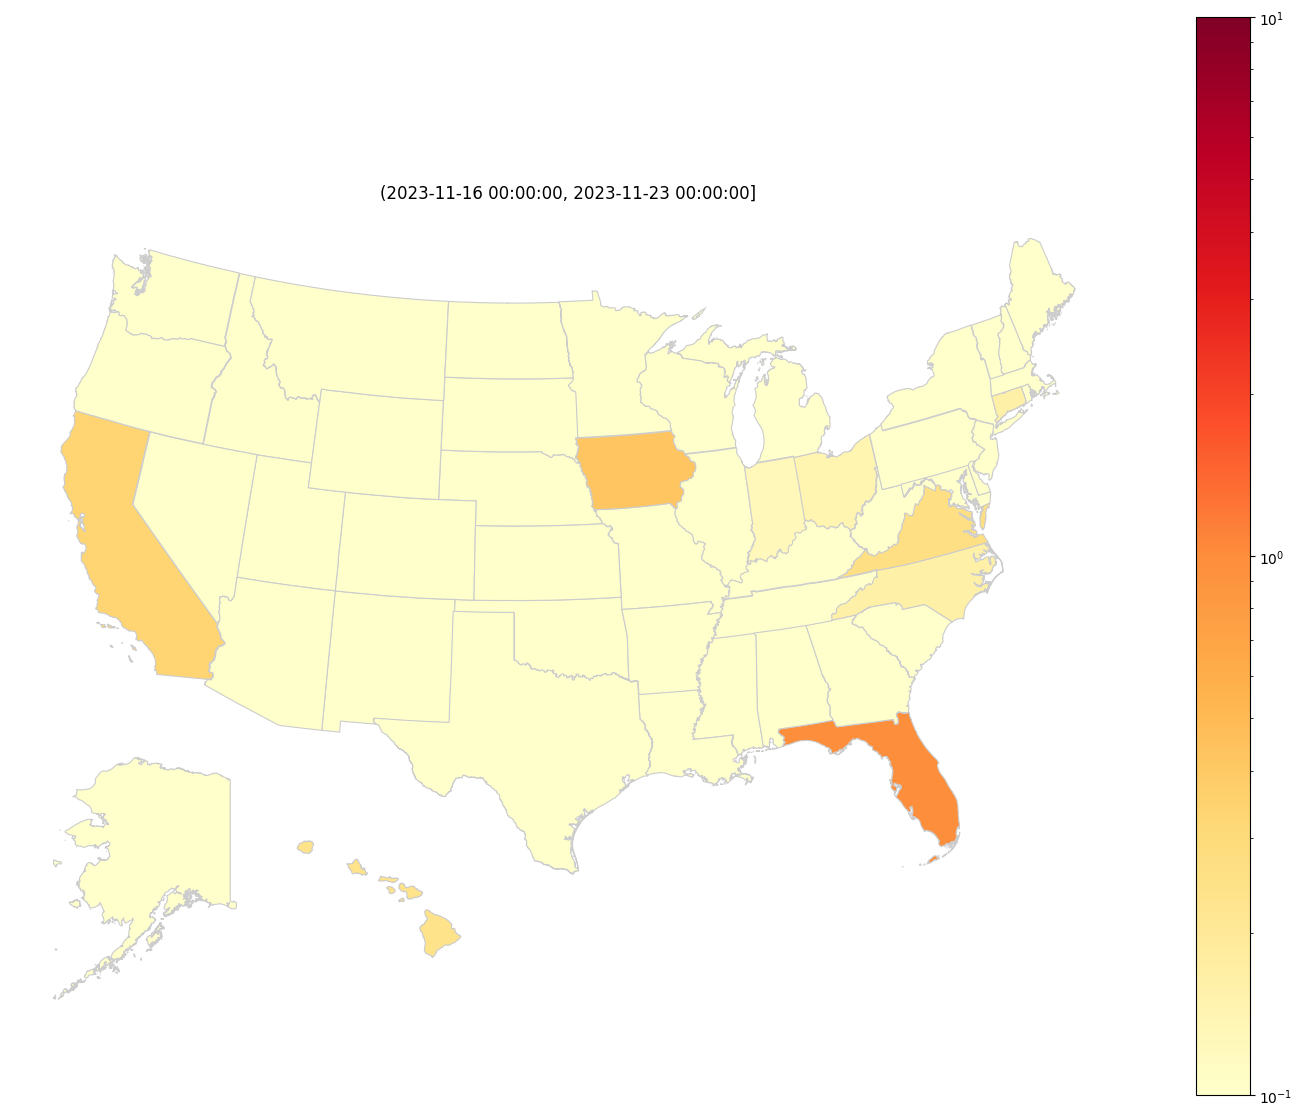

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


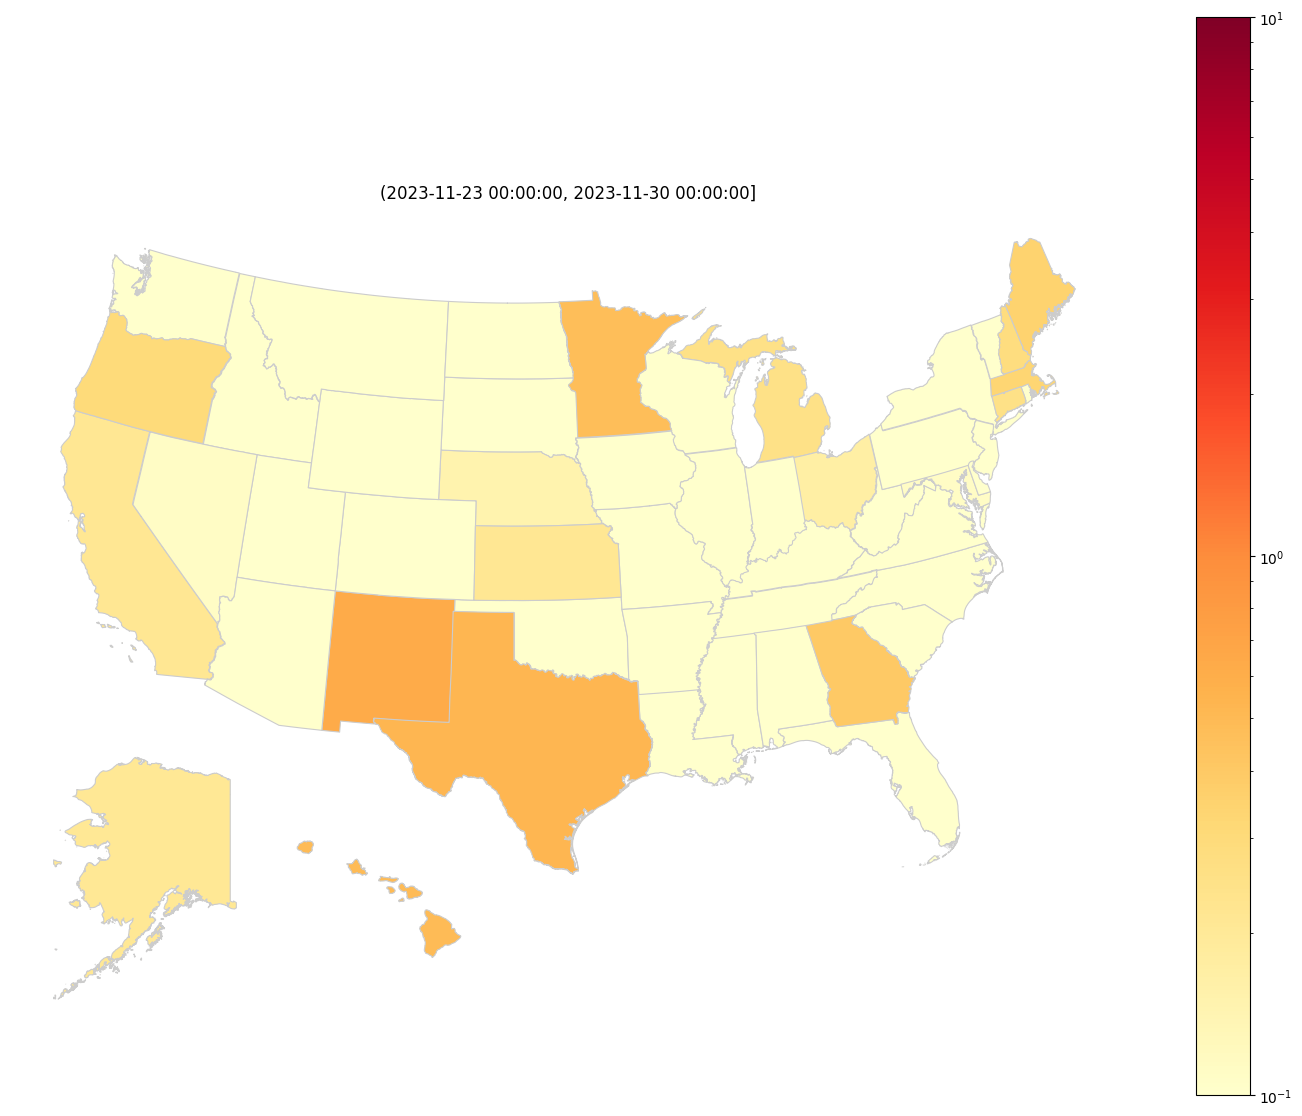

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


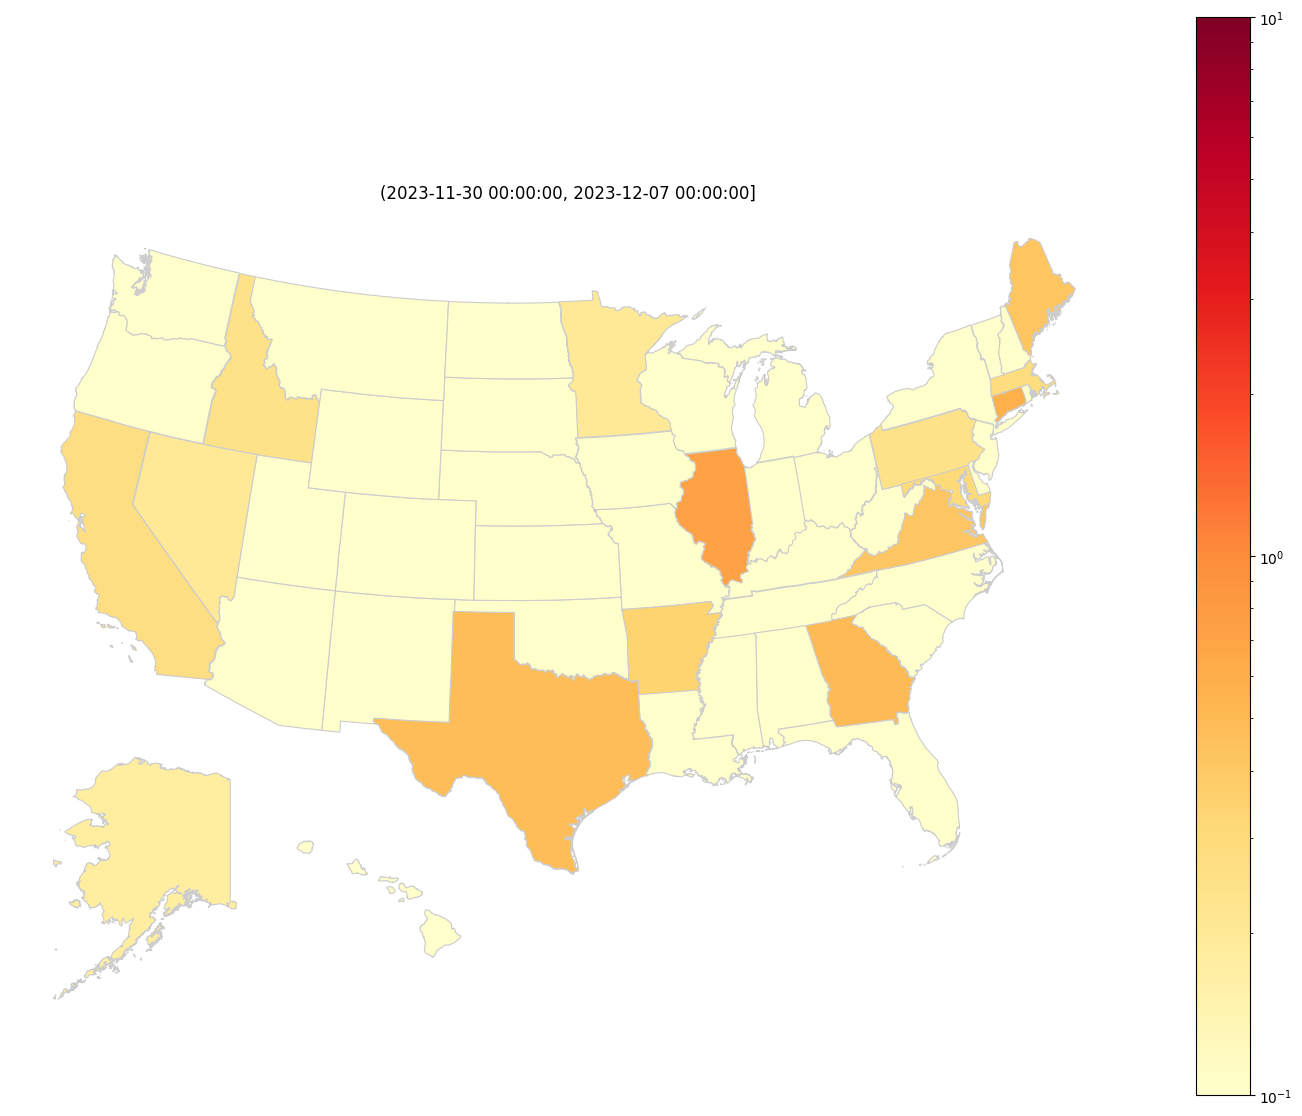

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


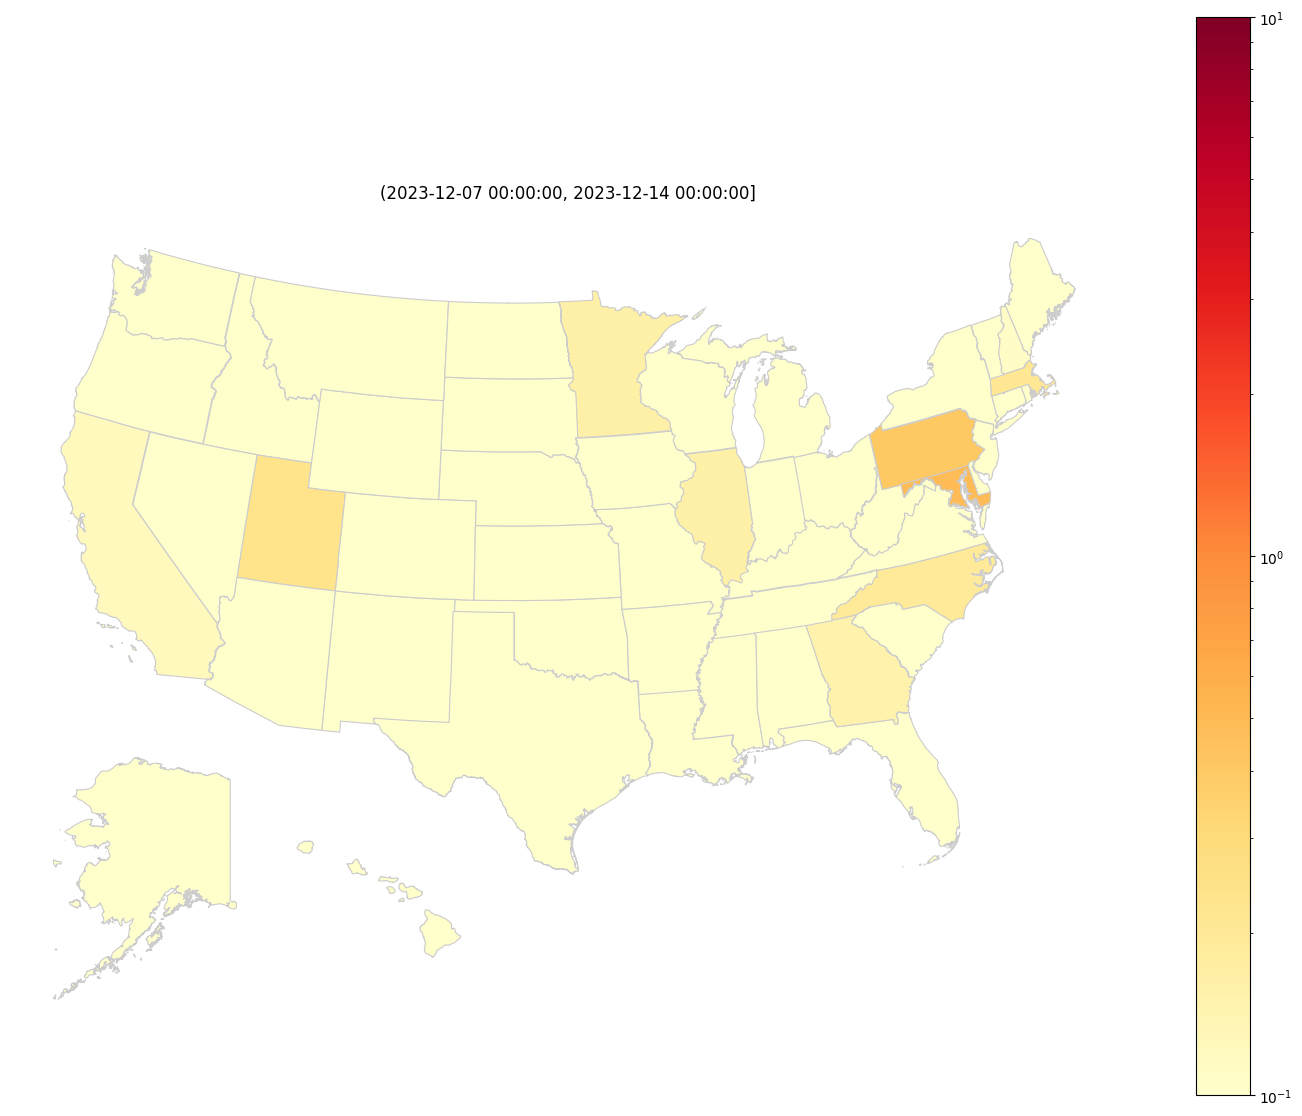

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


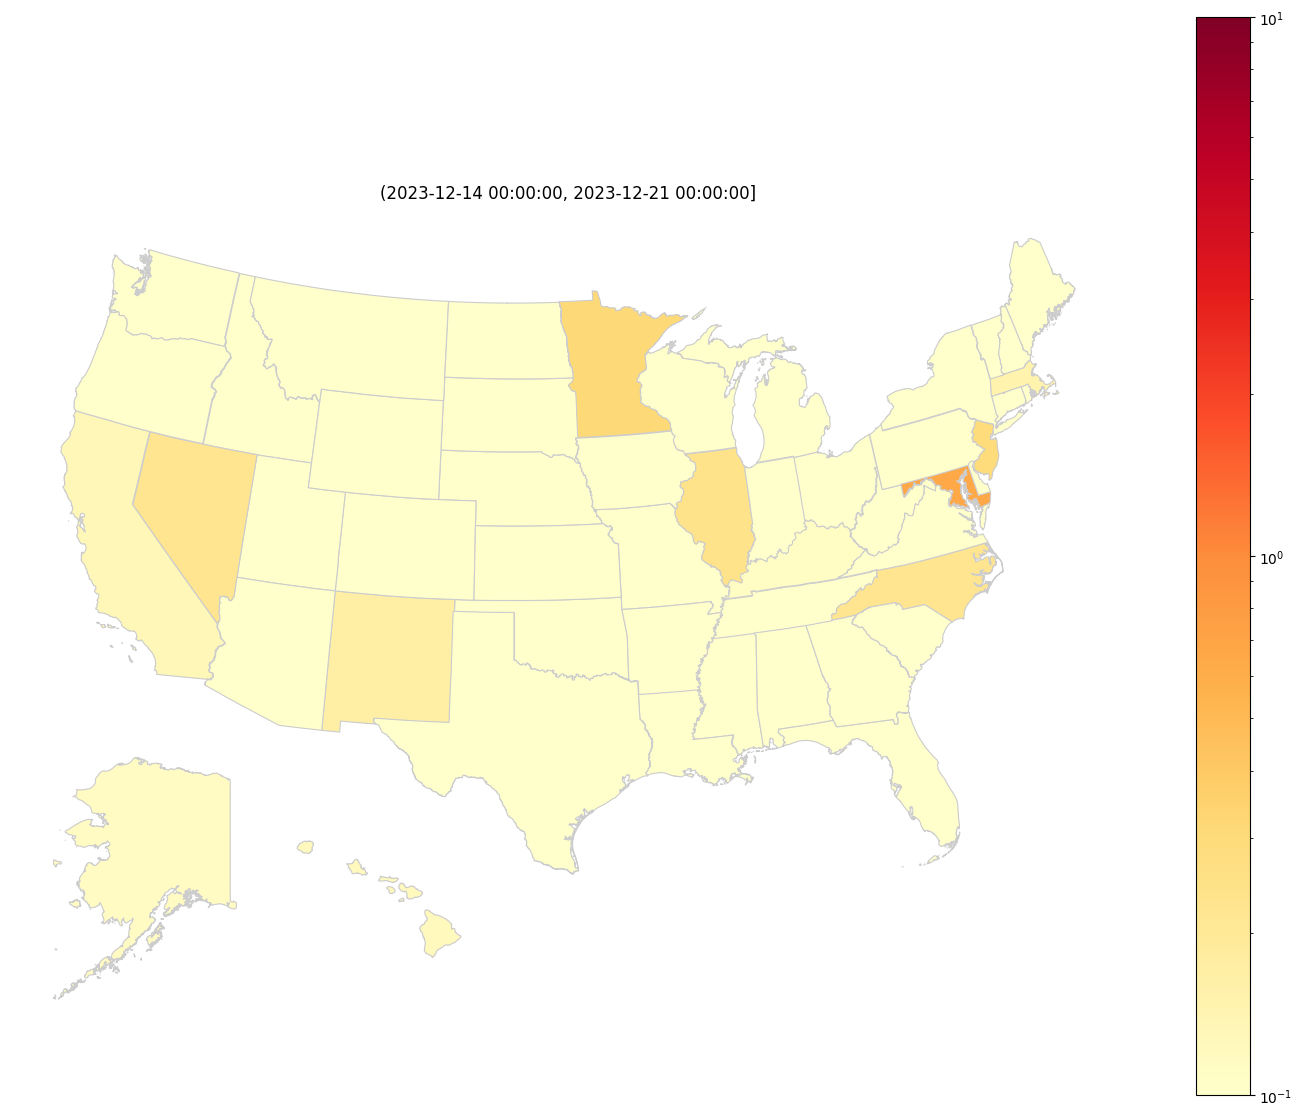

/home/emory/code/python-outbreak-info/outrbeakpy_venv/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


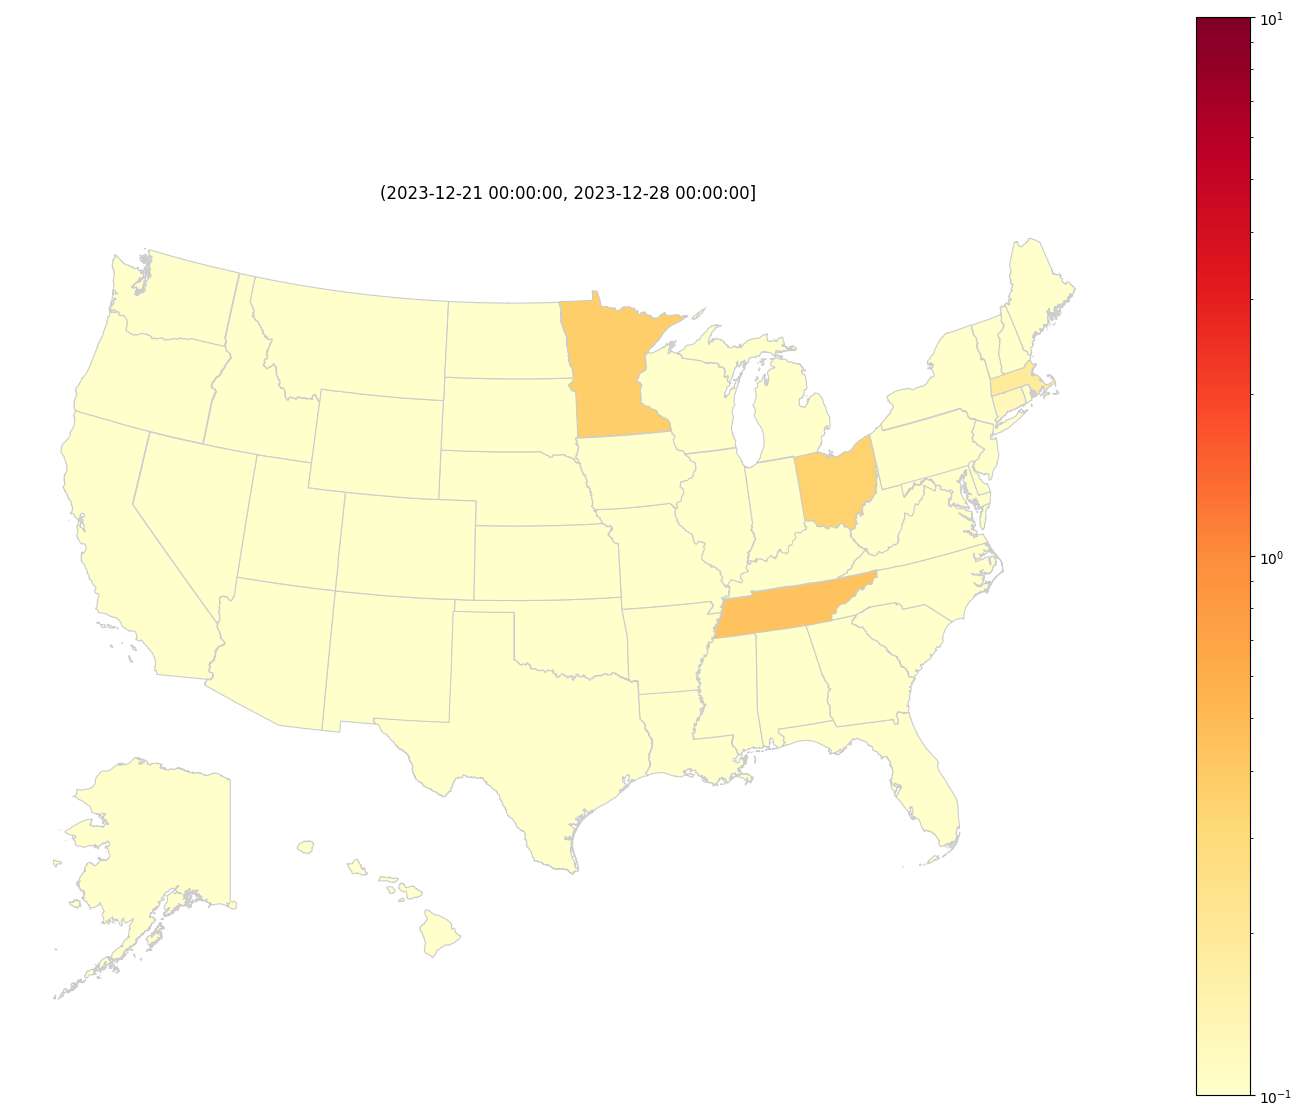

/tmp/ipykernel_840214/684310820.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [18]:
data['STUSPS'] = data['geo_loc_region'].apply(state_to_abbrev)
colors = plt.cm.ScalarMappable(cmap=cmap, norm=mcolors.LogNorm(vmin=1e-1, vmax=10, clip=True))
png_list = []
for datebin in np.sort(data['date_bin'].unique()):
    d = data[data['date_bin'] == datebin].set_index('STUSPS')['abundance']
    fig, ax = USmap(d, colors)
    fig.colorbar(colors, ax=ax)
    ax.set_title(datebin)
    plt.show()
    filename = f'map_frames/{lin}_map_wastewater_{datebin}.png'
    fig.savefig(filename)
    png_list.append(filename)

with imageio.get_writer(f'map_gifs/{lin}_ww_map.gif', mode='I', fps=2, loop=False) as writer:
    for filename in png_list:
        image = imageio.imread(filename)
        writer.append_data(image)